In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'1.12.1'

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

In [6]:
import torchvision

In [7]:
from torchvision import datasets, transforms

In [9]:
transformation = transforms.Compose([
    transforms.ToTensor()
])

In [10]:
train_ds = datasets.MNIST('data/',train=True,transform=transformation,download=False)
test_ds = datasets.MNIST('data/', train=False,transform=transformation,download=False)

In [11]:
train_ds

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [16]:
# dataset mnist 就是 一行行的数据, x, label, x,label....
imgs,labels = train_ds[0]

In [18]:
imgs.shape

torch.Size([1, 28, 28])

In [20]:
labels

5

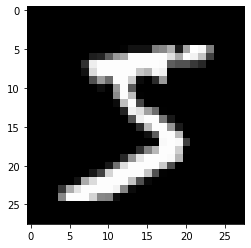

In [22]:
plt.imshow(imgs[0],cmap="gray")

In [23]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=64)

In [24]:
# 这时候要获取imgs 和 labels 就要用另外的形式了
imgs,labels = next(iter(train_dl)) 

In [25]:
imgs.shape

torch.Size([64, 1, 28, 28])

In [37]:
# 创建模型
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # 28*28 --> 24 * 24 --- 23*23---
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(6,16,5)
        self.linear_1 = nn.Linear(16*4*4, 256)
        self.linear_2 = nn.Linear(256,10)
    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 需要一个展平层
        x = x.view(-1,16*4*4)
        x =F.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

In [29]:
aa = torch.randn(2,1,28,28)

In [31]:
bb = nn.Conv2d(1,6,5)(aa)

In [32]:
bb.shape

torch.Size([2, 6, 24, 24])

In [33]:
cc = nn.MaxPool2d((2,2))(bb)

In [34]:
cc.shape

torch.Size([2, 6, 12, 12])

In [35]:
dd = nn.Conv2d(6,16,5)(cc)
dd.shape

torch.Size([2, 16, 8, 8])

In [36]:
ee = nn.MaxPool2d((2,2))(dd)
ee.shape

torch.Size([2, 16, 4, 4])

In [38]:
model = Model()

In [39]:
model.to(device)

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear_1): Linear(in_features=256, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=10, bias=True)
)

In [45]:
loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数
optim = torch.optim.Adam(model.parameters(), lr=0.001)

: 

In [40]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [43]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
epochs = 20
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.004 accuracy: 0.929 test_loss：  0.001 test_accuracy: 0.982
epoch:  1 loss：  0.001 accuracy: 0.979 test_loss：  0.001 test_accuracy: 0.985
epoch:  2 loss：  0.001 accuracy: 0.985 test_loss：  0.001 test_accuracy: 0.985
epoch:  3 loss：  0.001 accuracy: 0.988 test_loss：  0.001 test_accuracy: 0.988
epoch:  4 loss：  0.0 accuracy: 0.99 test_loss：  0.001 test_accuracy: 0.99
epoch:  5 loss：  0.0 accuracy: 0.992 test_loss：  0.001 test_accuracy: 0.989
epoch:  6 loss：  0.0 accuracy: 0.993 test_loss：  0.0 test_accuracy: 0.992
epoch:  7 loss：  0.0 accuracy: 0.994 test_loss：  0.001 test_accuracy: 0.99
epoch:  8 loss：  0.0 accuracy: 0.995 test_loss：  0.0 test_accuracy: 0.99
epoch:  9 loss：  0.0 accuracy: 0.995 test_loss：  0.001 test_accuracy: 0.989
epoch:  10 loss：  0.0 accuracy: 0.996 test_loss：  0.001 test_accuracy: 0.99
epoch:  11 loss：  0.0 accuracy: 0.997 test_loss：  0.001 test_accuracy: 0.99
epoch:  12 loss：  0.0 accuracy: 0.996 test_loss：  0.001 test_accuracy: 0.986
epoch:  13 

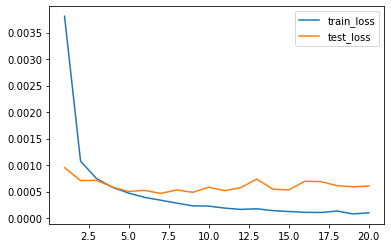

In [44]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

In [ ]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

In [ ]:
# 说明过拟合了,所以要添加dropout